# Eyettention

In [1]:
import numpy as np
#configuration
#English
cf = {"model_pretrained": "bert-base-cased",
      "atten_type": 'local-g',
      #batch computation for training (CELER dataset)
      "max_sn_len": 24,
      "max_sn_token": 35,
      "max_sp_len": 52
     }

#Chinese
#cf = {"model_pretrained": "bert-base-chinese",
      #"atten_type": 'local-g',
      #batch computation for training (BSC dataset)
      #"max_sn_len": 27,
      #"max_sp_len": 40
     #

In [17]:
import model
import torch
from torch.utils import model_zoo

#DEVICE = 'cuda'
DEVICE = 'cpu'

pretrained=True

#load model
dnn = model.Eyettention(cf)

if pretrained:
    dnn.load_state_dict(model_zoo.load_url('https://github.com/aeye-lab/Eyettention/releases/download/v1.0/Eyettention_english.pth', map_location=torch.device('cpu')))

keeping Bert with pre-trained weights


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
from transformers import BertTokenizerFast
#initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained(cf['model_pretrained'])

In [19]:
sentence = 'He said BankEast\'s offer appears to be "attractive to the bank\'s shareholders."'
#add special tokens
text = ('[CLS]' + ' ' + sentence + ' ' + '[SEP]').split()
print(text)
tokens = tokenizer(text, add_special_tokens=False, max_length=cf['max_sn_token'], padding='max_length', is_split_into_words=True)

['[CLS]', 'He', 'said', "BankEast's", 'offer', 'appears', 'to', 'be', '"attractive', 'to', 'the', "bank's", 'shareholders."', '[SEP]']


In [20]:
print(tokenizer.tokenize(text, add_special_tokens=False, is_split_into_words=True))

['[CLS]', 'He', 'said', 'Bank', '##E', '##ast', "'", 's', 'offer', 'appears', 'to', 'be', '"', 'attractive', 'to', 'the', 'bank', "'", 's', 'shareholders', '.', '"', '[SEP]']


In [21]:
print(tokens)

{'input_ids': [101, 1124, 1163, 2950, 2036, 12788, 112, 188, 2906, 2691, 1106, 1129, 107, 8394, 1106, 1103, 3085, 112, 188, 16741, 119, 107, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


In [22]:
#use offset mapping to assign a word index to each token.
#index start from 0, CLS -> 0 and SEP -> last index
word_ids = tokens.word_ids()
word_ids = [val if val is not None else np.nan for val in word_ids]
print(word_ids)

In [24]:
def compute_word_length(txt):
    txt_word_len = [len(t) for t in txt[1:-1]]
    #pad nan for CLS and SEP tokens
    txt_word_len = [np.nan] + txt_word_len + [np.nan]
    #length of a punctuation is 0, plus an epsilon to avoid division output inf
    arr = np.array(txt_word_len).astype('float64')
    arr[arr==0] = 1/(0+0.5)
    arr[arr!=0] = 1/(arr[arr!=0])
    return arr

def pad_seq(seqs, max_len, dtype=np.int32, fill_value=np.nan):
    padded = np.full((len(seqs), max_len), fill_value=fill_value, dtype=dtype)
    for i, seq in enumerate(seqs):
        padded[i, :len(seq)] = seq
    return padded

In [25]:
#compute the word length feature
text_word_len = [compute_word_length(txt) for txt in [text]]
text_word_len = pad_seq(text_word_len, cf['max_sn_len'], fill_value=np.nan, dtype=np.float32)
print(text_word_len)

In [27]:
#load precomputed sn_word_len mean and std (from CELER dataset)
# you can download the file from https://github.com/aeye-lab/Eyettention/releases/download/v1.0/.
import pickle
path = 'feature_norm_celer.pickle'
file_to_read = open(path, "rb")
loaded_dictionary = pickle.load(file_to_read)
sn_word_len_mean = loaded_dictionary['sn_word_len_mean']
sn_word_len_std = loaded_dictionary['sn_word_len_std']

In [28]:
#normalize word length feature
text_word_len = (text_word_len - sn_word_len_mean)/sn_word_len_std
text_word_len = np.nan_to_num(text_word_len)

In [29]:
tokens['input_ids'] = torch.tensor([tokens['input_ids']]).to(DEVICE)
tokens['attention_mask'] = torch.tensor([tokens['attention_mask']]).to(DEVICE)
word_ids = torch.tensor([word_ids]).to(DEVICE)
word_len = torch.tensor([text_word_len.squeeze()]).to(DEVICE)

In [30]:
from sklearn.preprocessing import LabelEncoder
#prepare the saccade range classes for model predictions, cf["max_sn_len"]-1 -> stop class
le = LabelEncoder()
le.fit(np.append(np.arange(-cf["max_sn_len"]+3, cf["max_sn_len"]-1), cf["max_sn_len"]-1))
#le.classes_

LabelEncoder()

In [52]:
syn_scanpath, density_pred = dnn.scanpath_generation(sn_emd=tokens['input_ids'],\
                                                     sn_mask=tokens['attention_mask'],\
                                                     word_ids_sn=word_ids,\
                                                     sn_word_len = word_len,\
                                                     le=le,\
                                                     max_pred_len=50)\

In [45]:
def post_process_scanpath(syn_scanpath, sn_len):
    syn_scanpath = syn_scanpath.detach().to('cpu').numpy()
    max_sp_len = syn_scanpath.shape[1]
    
    #Find the number "sn_len+1" -> the stop class
    stop_indx = []
    for i in range(syn_scanpath.shape[0]):
        stop = np.where(syn_scanpath[i,:]==(sn_len[i]+1))[0]
        if len(stop)==0:#no stop class can be find -> exceeds the maximum length of the generated scanpath
            stop_indx.append(max_sp_len-1)
        else:
            stop_indx.append(stop[0])

    #Truncating data after the stop class
    syn_scanpath_cut = [syn_scanpath[i][1:stop_indx[i]] for i in range(syn_scanpath.shape[0])]
    return syn_scanpath_cut

In [53]:
sn_len = (torch.max(torch.nan_to_num(word_ids), dim=1)[0]+1-2).detach().to('cpu').numpy()
syn_scanpath = post_process_scanpath(syn_scanpath, sn_len)
print(syn_scanpath[0])

['He', 'said', "BankEast's", 'offer', 'offer', 'be', '"attractive', 'the', "bank's", 'the', 'to', '"attractive', 'shareholders."', "bank's", 'the', 'to', '"attractive', "bank's", '"attractive', '"attractive', "bank's", 'shareholders."', 'He']


In [ ]:
fixated_word = [text[idx] for idx in syn_scanpath[0]] 
print(fixated_word)

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_distribution(syn_scanpath, density_pred, timestep, text):
    #visualize density map
    plt.figure(figsize = (25,5))
    sac_range = np.append(np.arange(-cf["max_sn_len"]+3, cf["max_sn_len"]-1), cf["max_sn_len"]-1)
    
    #current gaze position
    cur_loc = syn_scanpath[timestep]
    #convert the saccade range classes to the target word indexes
    target_loc = sac_range + cur_loc
    
    prob_valid = density_pred[np.where((0 <= target_loc) & (target_loc <= (len(text)-2)))]#exclude SEP token
    prob_valid = np.append(prob_valid, density_pred[-1])
    
    plt.subplot(2, 1, 2)
    sns.heatmap(prob_valid[np.newaxis, :], annot=np.array(text)[np.newaxis,:], fmt="", linewidths=2, cmap="YlGnBu", xticklabels=False, yticklabels=False, cbar=True, annot_kws={"fontsize":15}, cbar_kws = dict(use_gridspec=False,location="top"))
    y = 3
    for past_ts in range(timestep):
        dy = 0
        dx = syn_scanpath[past_ts+1] - syn_scanpath[past_ts]
        #if refixation, display on next line
        if dx <= 0:
            dy = -0.5
            plt.arrow(syn_scanpath[past_ts]+0.5, y, dx, dy, color='b', ec ='blue', head_width=0.2)
            y = y + dy
        else:
            plt.arrow(syn_scanpath[past_ts]+0.5, y, dx, dy, color='b', ec ='blue', head_width=0.2)

    plt.arrow(syn_scanpath[timestep]+0.5, y, (syn_scanpath[timestep+1]-syn_scanpath[timestep]), 0, color='r', ec ='red', head_width=0.2)
    plt.xlim([0, len(text)])
    plt.ylim([0, 3.5])
    ax = plt.gca()
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

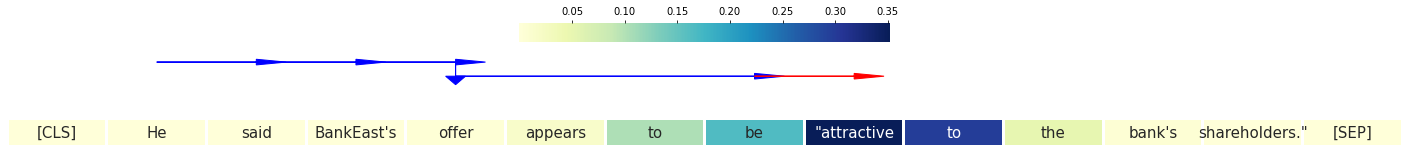

In [96]:
sample_index=0
timestep = 5
visualize_distribution(syn_scanpath=syn_scanpath[sample_index], 
                       density_pred=density_pred[timestep][sample_index].detach().numpy(), 
                       timestep=timestep, 
                       text=text)

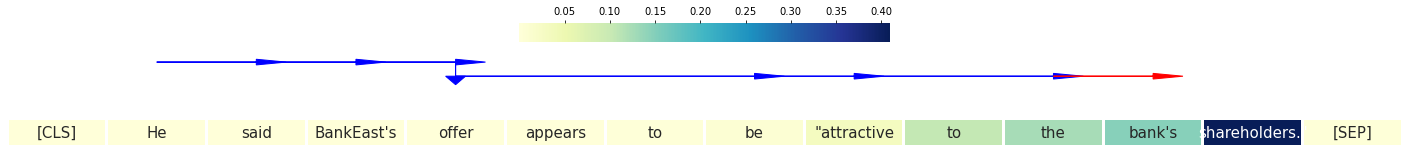

In [98]:
sample_index=0
timestep = 7
visualize_distribution(syn_scanpath=syn_scanpath[sample_index], 
                       density_pred=density_pred[timestep][sample_index].detach().numpy(), 
                       timestep=timestep, 
                       text=text)